# GTHA housing market database
# OSEMN methodology Step 4: Model
# Two features
---

This notebook describes _Step 4: Model_ of OSEMN methodology performed on the Teranet dataset.

## Import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import os
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from time import time

sns.set()

In [3]:
import sys

sys.path.append('../../src')

from plot_utils import plot_hist
from model_utils import plot_decision_regions, fit_model

## Load Teranet data

In [4]:
data_path = '../../data/teranet/'
os.listdir(data_path)

['1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 '2_Teranet_consistent.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '4_Teranet_lu_encode.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [5]:
t = time()

df = pd.read_csv(data_path + '4_Teranet_lu_encode.csv',
                 parse_dates=['registration_date'], low_memory=False)
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- DataFrame loaded
in 90.71 seconds (1.51 minutes)
with 5,188,513 rows
and 78 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'pric

## Load Census data

In [7]:
census_path = data_path + '../da_census/'
os.listdir(census_path)

['da_census_income.csv',
 'Census data availability.xlsx',
 'da_census.xls',
 'da_census_select_tidy.csv',
 'da_census_income_shapefile',
 '.ipynb_checkpoints',
 'da_census_select.csv']

In [8]:
t = time()

census_df = pd.read_csv(census_path + 'da_census_select_tidy.csv')
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(census_df.shape[0], census_df.shape[1]) + 
      "\n-- Column names:\n", census_df.columns)

----- DataFrame loaded
in 0.23 seconds (0.00 minutes)
with 36,728 rows
and 32 columns
-- Column names:
 Index(['DAUID', 'year', 'Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt',
       'Avg_val_dwel', 'Avg_rent', 'Pop', 'PopDens', 'Dwel', 'DwelDens',
       'Sgl_det', 'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d',
       'CarTrVan_p', 'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp',
       'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl',
       'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object')


## Join Census data to Teranet data

In [10]:
df = pd.merge(df, census_df, how='left',
              left_on=['dauid', 'census2001_year'], right_on=['DAUID', 'year'])
df = df.drop(['DAUID', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
print("----- Census variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- Census variables were joined to the DataFrame
in 0.23 seconds (0.00 minutes)
with 5,188,513 rows
and 108 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Emp', 'Unemp', 'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home',
       'No_fix_wkpl', 'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object', length=108)


## Take a subset of Teranet records

In [14]:
year = 2011
s = df.query('year == @year')
print("{0:,} records in the subset".format(len(s)))

219,130 records in the subset


## Take validation subsets from Teranet records

In [15]:
year_val1 = 2011
s_val1 = df.query('year == @year_val1')
print("{0:,} records in the subset".format(len(s_val1)))

219,130 records in the subset


In [16]:
year_val2 = 2013
s_val2 = df.query('year == @year_val2')
print("{0:,} records in the subset".format(len(s_val2)))

207,686 records in the subset


## Select features

In [20]:
s.columns[-60:]

Index(['pin_price_pct_change', 'xy_price_pct_change', 'price_da_pct_change',
       'med_price_xy', 'med_price_year', 'price_to_med_xy',
       'price_to_med_year', 'outlier_y_3', 'outlier_y_5', 'outlier_y_10',
       'outlier_y_20', 'outlier_xy_2', 'outlier_xy_4', 'outlier_xy_10', 'code',
       'lu_class', 'luc_detached', 'luc_condo', 'luc_strata', 'luc_duplex',
       'luc_townhouse', 'luc_mixuse', 'luc_underdeveloped', 'luc_mixedcomplex',
       'luc_industrial', 'luc_commercial', 'lucr_house', 'lucr', 'lucr_condo',
       'lucr_other', 'Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt', 'Avg_val_dwel',
       'Avg_rent', 'Pop', 'PopDens', 'Dwel', 'DwelDens', 'Sgl_det',
       'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d', 'CarTrVan_p',
       'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp', 'Not_lbrfrc',
       'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl', 'Usl_wkpl',
       'Blue_cljob', 'White_cljob'],
      dtype='object')

In [21]:
feat_1 = 'Avg_HHsize'
feat_2 = 'xy_years_to_next_sale'

s = s.dropna(subset=[feat_1, feat_2])
s_val1 = s_val1.dropna(subset=[feat_1, feat_2])
s_val2 = s_val2.dropna(subset=[feat_1, feat_2])
print("{0:,} rows in train-test subset, {1:,} rows in validation subset #1, {2:,} rows in validation subset #2"
      .format(len(s), len(s_val1), len(s_val2)))

155,461 rows in train-test subset, 155,461 rows in validation subset #1, 135,602 rows in validation subset #2


## Exploratory Data Analysis (EDA)

In [32]:
from scipy.stats import norm, shapiro, normaltest

def fit_norm_dist(series, h_bins='auto',
                  create_figure=True, ax=None,
                  show_plot=True, suptitle=None,
                  title=None, xlabel=None, ylabel='Distribution',
                  figsize=(6, 6), lab2='from_mean',
                  mean_lift=0.99, std_lift=1.007,
                  sig_lift=0.03, per_lift=0.1, val_lift=0.23,
                  x_between=None, x_min=None, x_max=None,
                  t_shapiro=True, t_k2=True):
    """
    :param series: pandas Series
        Series to be plotted
    :param h_bins: int
        number of bins to for histogram (default='auto')
    :param create_figure: Boolean
        whether to initialize matplotlib figure and axis
        (default=True)
    :param ax: matplotlib axis
        matplotlib axis to plot on (for multi-plot figures)
    :param show_plot: Boolean
        whether to show plot at the end (default=True)
    :param suptitle: string
        string to use for plot suptitle
    :param title: string
        string to use for plot title
    :param xlabel: string
        string to use for x axis label
    :param ylabel: string
        string to use for y axis label
    :param figsize: tuple(float, float)
        size of the figure
    :param lab2: string (must be 'cdf' or 'from_mean'
        which percentage values to display (CDF or from mean)
        (default='from_mean')
    :param mean_lift: float
        lift for mean caption
    :param std_lift: float
        lift for std caption
    :param sig_lift: float
        lift for sigma captions
    :param per_lift: float
        lift for percentage captions
    :param val_lift: float
        lift for values captions
    :param x_min: float
        estimate probability that x > x_min
    :param x_max: float
        estimate probability that x < x_max
    :param x_between: tuple(float, float)
        estimate probability that x_min < x < x_max
    :return: series.describe()
        statistical summary of the plotted Series
    """
    if create_figure:
        f, ax = plt.subplots(1, figsize=figsize)
        if suptitle:
            f.suptitle(suptitle)
    # plot data
    n, bins, patches = plt.hist(x=series, bins=h_bins)
    mu = series.mean()
    sigma = series.std()
    # initialize a normal distribution
    nd = norm(mu, sigma)
    # plot mean std
    ax.axvline(mu, color='black', linestyle='--')
    ax.text(mu * mean_lift, n.max() * 0.4,
            "Mean: {0:.2f}".format(mu),
            rotation='vertical')
    ax.text(mu * std_lift, n.max() * 0.4,
            "StDev: {0:.2f}".format(sigma),
            rotation='vertical')
    # generate sigma lines and labels
    i = np.arange(-3, 4)
    vlines = mu + i * sigma
    labels1 = pd.Series(i).astype('str') + '$\sigma$'
    if lab2 == 'cdf':
        labels2 = pd.Series(nd.cdf(vlines) * 100) \
                      .round(2).astype('str') + '%'
    elif lab2 == 'from_mean':
        labels2 = pd.Series(abs(50 - nd.cdf(vlines) * 100) * 2) \
                      .round(2).astype('str') + '%'
    else:
        raise AttributeError("Parameter 'lab2' must be either set to 'cdf' or 'from_mean'")
    labels2 = labels2.astype('str')

    # plot sigma lines and labels
    for vline, label1, label2 in zip(vlines, labels1, labels2):
        # plot sigma lines
        if vline != mu:
            ax.axvline(vline, linestyle=':', color='salmon')
            ax.text(vline, n.max() * sig_lift, label1)
        ax.text(vline, n.max() * per_lift, label2, rotation=45)
        ax.text(vline, n.max() * val_lift,
                round(vline, 2), rotation=45)

    # fit a normal curve
    # generate x in range of mu +/- 5 sigma
    x = np.linspace(mu - 5 * sigma, mu + 5 * sigma,
                    1000)
    # calculate PDF
    y = nd.pdf(x)
    # plot fitted distribution
    ax2 = ax.twinx()
    ax2.plot(x, y, color='red', label='Fitted normal curve')
    ax2.legend(loc='best')
    ax2.set_ylim(0)

    if not xlabel:
        xlabel = series.name
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    if not title:
        title = "Histogram of {0}".format(series.name)
    ax.set_title(title)

    ax.grid(False)
    ax2.grid(False)

    if x_min:
        # estimate probability that x > x_min
        p = (1 - nd.cdf(x_min)) * 100
        ax.text(mu - 5 * sigma, n.max() * 0.9, "$P ~ ( X > {0} ) ~ = $".format(x_min) +
                "\n$ = {0:.2f}\%$".format(p))
        ax2.fill_between(x, 0, y, color='red', alpha=0.2,
                         where=x > x_min)
        mask = series > x_min
        print("Using normal distribution, from the total {0:,} records in the Series, "
              "{1:,.0f} are expected to have {2} > {3}"
              .format(len(series), len(series) * p / 100, series.name, x_min),
              "\n\nActual number of records with {0} > {1}: {2:,}"
              .format(series.name, x_min, len(series[mask])))
    elif x_max:
        # estimate probability that x > x_min
        p = nd.cdf(x_max) * 100
        ax.text(mu - 5 * sigma, n.max() * 0.9, "$P ~ ( X < {0} ) ~ = $".format(x_max) +
                "\n$ = {0:.2f}\%$".format(p))
        ax2.fill_between(x, 0, y, color='red', alpha=0.2,
                         where=x < x_max)
        mask = series < x_max
        print("Using normal distribution, from the total {0:,} records in the Series, "
              "{1:,.0f} are expected to have {2} < {3}"
              .format(len(series), len(series) * p / 100, series.name, x_max),
              "\n\nActual number of records with {0} < {1}: {2:,}"
              .format(series.name, x_max, len(series[mask])))
    elif x_between:
        # estimate probability that x_min < x < x_max
        x_min, x_max = x_between
        p = (nd.cdf(x_max) - nd.cdf(x_min)) * 100
        ax.text(mu - 5 * sigma, n.max() * 0.9, "$P ~ ( {0} < X < {1} ) ~ = $".format(x_min, x_max) +
                "\n$ = {0:.2f}\%$".format(p))
        ax2.fill_between(x, 0, y, color='red', alpha=0.2,
                         where=np.logical_and(x > x_min, x < x_max))
        mask = np.logical_and(series < x_max, series > x_min)
        print("Using normal distribution, from the total {0:,} records in the Series, "
              "{1:,.0f} are expected to have {2} < {3} < {4}"
              .format(len(series), len(series) * p / 100, x_min, series.name, x_max),
              "\n\nActual number of records with {0} < {1} < {2}: {3:,}"
              .format(x_min, series.name, x_max, len(series[mask])))

    if show_plot:
        plt.show()

    if t_shapiro:
        stat, p = shapiro(series.dropna())
        print("\n----- Shapiro-Wilks normality test results:\nW = {0:.3f}, p-value = {1:.3f}"
              .format(stat, p))

    if t_k2:
        stat, p = normaltest(series.dropna())
        print("\n----- D’Agostino’s K^2 normality test results:"
              "\ns^2 + k^2 = {0:.3f}, p-value = {1:.3f},"
              .format(stat, p) + "\nwhere s is the z-score returned "
                                 "by skewtest and k is the z-score returned by kurtosistest"
                                 "\nand p-value is a 2-sided chi squared probability for the hypothesis test.")

    return series.describe()

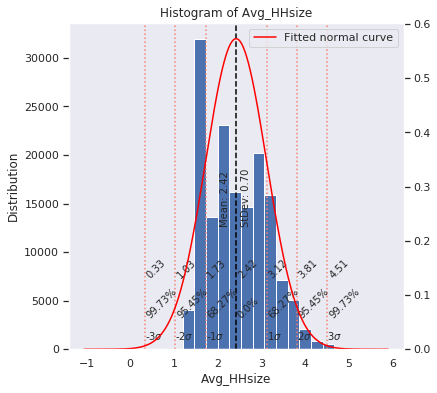


----- Shapiro-Wilks normality test results:
W = 0.956, p-value = 0.000

----- D’Agostino’s K^2 normality test results:
s^2 + k^2 = 10656.595, p-value = 0.000,
where s is the z-score returned by skewtest and k is the z-score returned by kurtosistest
and p-value is a 2-sided chi squared probability for the hypothesis test.


count    155461.000000
mean          2.422107
std           0.696253
min           1.200000
25%           1.800000
50%           2.333333
75%           2.966667
max           5.200000
Name: Avg_HHsize, dtype: float64

In [33]:
fit_norm_dist(s[feat_1], h_bins=15, lab2='from_mean', mean_lift=0.85, std_lift=1.05)

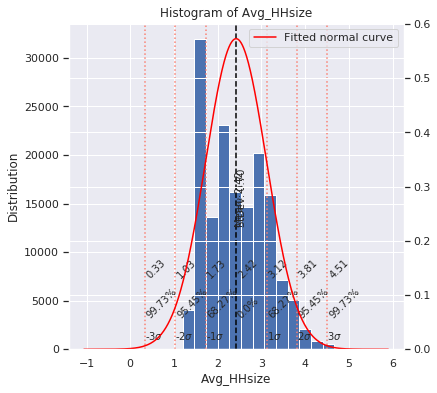


----- Shapiro-Wilks normality test results:
W = 0.956, p-value = 0.000

----- D’Agostino’s K^2 normality test results:
s^2 + k^2 = 10656.595, p-value = 0.000,
where s is the z-score returned by skewtest and k is the z-score returned by kurtosistest
and p-value is a 2-sided chi squared probability for the hypothesis test.


count    155461.000000
mean          2.422107
std           0.696253
min           1.200000
25%           1.800000
50%           2.333333
75%           2.966667
max           5.200000
Name: Avg_HHsize, dtype: float64

In [23]:
max_ratio = 2
mask1 = s[feat_1] < max_ratio
fit_s = s[mask1]
fit_norm_dist(s[feat_1], h_bins=15, lab2='from_mean')

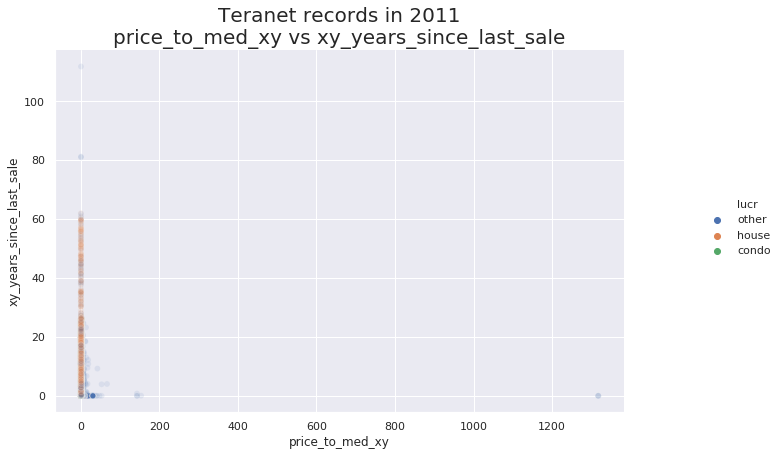

In [9]:
g = sns.relplot(data=s, x=feat_1, y=feat_2, hue='lucr', alpha=0.1)
g.fig.set_size_inches(12, 6)
ax = plt.gca()
ax.set_title("Teranet records in {0}\n{1} vs {2}".format(year, feat_1, feat_2), fontsize=20)
plt.show()

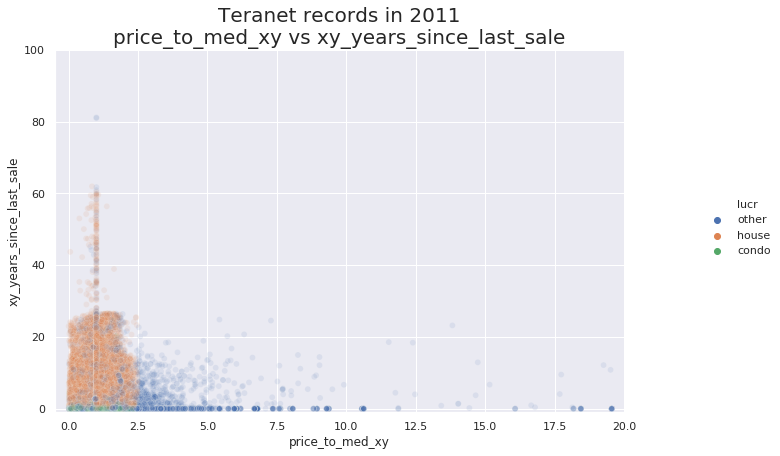

In [10]:
g = sns.relplot(data=s, x=feat_1, y=feat_2, hue='lucr', alpha=0.1)
g.fig.set_size_inches(12, 6)
ax = plt.gca()
ax.set_title("Teranet records in {0}\n{1} vs {2}".format(year, feat_1, feat_2), fontsize=20)
ax.set_xlim(-0.5, 20)
ax.set_ylim(-1, 100)
plt.show()

## Prepare features and target

### Encode target

In [11]:
le = LabelEncoder()
s['lucr_e'] = le.fit_transform(s['lucr'])
print("Land use encoded!")
labels = {0: 'condo', 1: 'house', 2: 'other'}
labels_list = ['condo', 'house', 'other']
s['lucr_e'].value_counts().sort_index()

Land use encoded!


0    62144
1    62551
2    66378
Name: lucr_e, dtype: int64

In [12]:
le = LabelEncoder()
s_val['lucr_e'] = le.fit_transform(s_val['lucr'])
print("Land use encoded!")
s_val['lucr_e'].value_counts().sort_index()

Land use encoded!


0    54994
1    61450
2    60059
Name: lucr_e, dtype: int64

In [13]:
labels

{0: 'condo', 1: 'house', 2: 'other'}

#### Select features and target

In [14]:
X = s[[feat_1, feat_2]].values
y = s['lucr_e'].values
print("Features and target selected.")

Features and target selected.


In [15]:
X_val = s_val[[feat_1, feat_2]].values
y_val = s_val['lucr_e'].values
print("Features and target selected.")

Features and target selected.


#### Perform train-test split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
print("Performed train-test split.")

Performed train-test split.


In [17]:
len(X_train)

133751

In [18]:
len(y_train)

133751

In [19]:
len(X_test)

57322

In [20]:
len(y_test)

57322

In [21]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))
print('Labels counts in y_val:', np.bincount(y_val))

Labels counts in y: [62144 62551 66378]
Labels counts in y_train: [43501 43786 46464]
Labels counts in y_test: [18643 18765 19914]
Labels counts in y_val: [54994 61450 60059]


#### Standardize features

In [22]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
print("Input features were standardized.")

Input features were standardized.


In [23]:
X_val_std = sc.transform(X_val)
print("Input features were standardized.")

Input features were standardized.


#### Recombine inputs and targets

In [24]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
print("Input and target recombined.")

Input and target recombined.


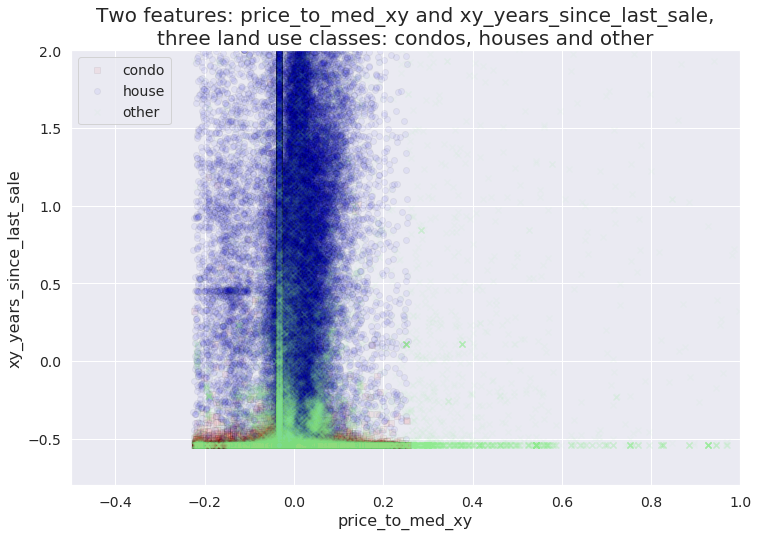

In [25]:
markers = ('s', 'o', 'x', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:len(np.unique(y_combined))])
plt.figure(figsize=(12, 8))
for idx, cl in enumerate(np.unique(y_combined)):
    plt.scatter(x=X_combined_std[y_combined == cl, 0], y=X_combined_std[y_combined == cl, 1],
                c=colors[idx], marker=markers[idx], label=cl, edgecolor='black', alpha=0.05)
plt.xlim(-0.5, 1)
plt.ylim(-0.8, 2)
plt.xlabel(feat_1, fontsize=16)
plt.ylabel(feat_2, fontsize=16)
plt.title("Two features: {0} and {1},\nthree land use classes: condos, houses and other"
          .format(feat_1, feat_2),
          fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=labels_list, loc='upper left', fontsize=14)
plt.show()

### Train and test classification algorithms

#### Perceptron learning algorithm

In [26]:
t = time()

# initialize and fit a model
ppn = Perceptron(max_iter=100, eta0=0.01, random_state=1)
ppn.fit(X_train_std, y_train)

# make predictions
y_pred_train = ppn.predict(X_train_std)
y_pred_test = ppn.predict(X_test_std)
y_pred_val = ppn.predict(X_val_std)

# score model performance
train_score = accuracy_score(y_train, y_pred_train)
test_score = accuracy_score(y_test, y_pred_test)
val_score = accuracy_score(y_val, y_pred_val)

elapsed = time() - t
print("Model fit, took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))

Model fit, took 0.24 seconds (0.00 minutes)


Plotting took 4.62 seconds (0.08 minutes)


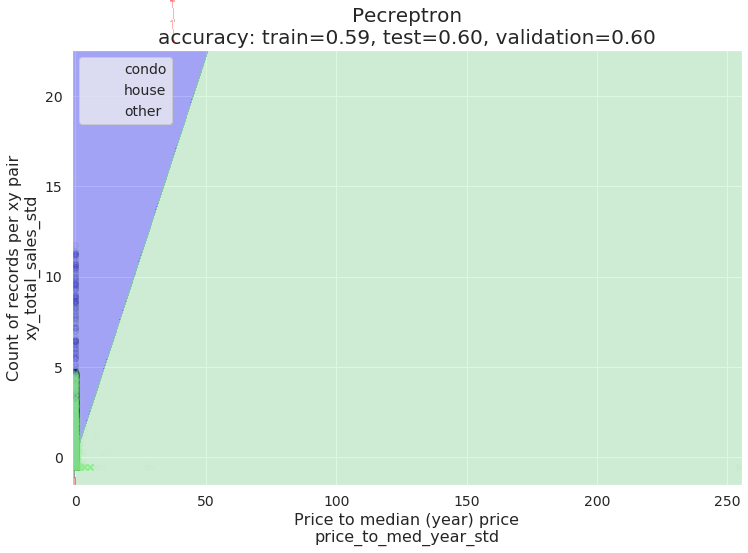

In [27]:
t = time()
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=ppn,
                      limits=False)
plt.xlabel("Price to median (year) price\nprice_to_med_year_std", fontsize=16)
plt.ylabel("Count of records per xy pair\nxy_total_sales_std", fontsize=16)
plt.title("Pecreptron\naccuracy: train={0:.2f}, test={1:.2f}, validation={2:.2f}"
          .format(train_score, test_score, val_score), fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=labels_list, loc='upper left', fontsize=14)
elapsed = time() - t
print("Plotting took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
plt.show()

Plotting took 4.57 seconds (0.08 minutes)


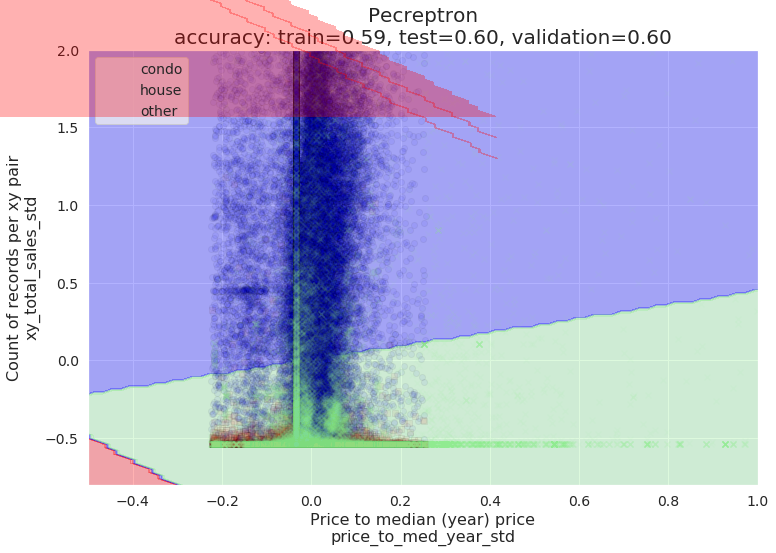

In [28]:
t = time()
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=ppn,
                      limits=True)
plt.xlabel("Price to median (year) price\nprice_to_med_year_std", fontsize=16)
plt.ylabel("Count of records per xy pair\nxy_total_sales_std", fontsize=16)
plt.title("Pecreptron\naccuracy: train={0:.2f}, test={1:.2f}, validation={2:.2f}"
          .format(train_score, test_score, val_score), fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=labels_list, loc='upper left', fontsize=14)
elapsed = time() - t
print("Plotting took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
plt.show()

#### Logistic regression

In [29]:
t = time()

# initialize and fit a model
model = LogisticRegression(C=100.0, random_state=1)
model.fit(X_train_std, y_train)

# make predictions
y_pred_train = model.predict(X_train_std)
y_pred_test = model.predict(X_test_std)
y_pred_val = model.predict(X_val_std)

# score model performance
train_score = accuracy_score(y_train, y_pred_train)
test_score = accuracy_score(y_test, y_pred_test)
val_score = accuracy_score(y_val, y_pred_val)

elapsed = time() - t
print("Model fit, took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Model fit, took 0.74 seconds (0.01 minutes)


Plotting took 4.27 seconds (0.07 minutes)


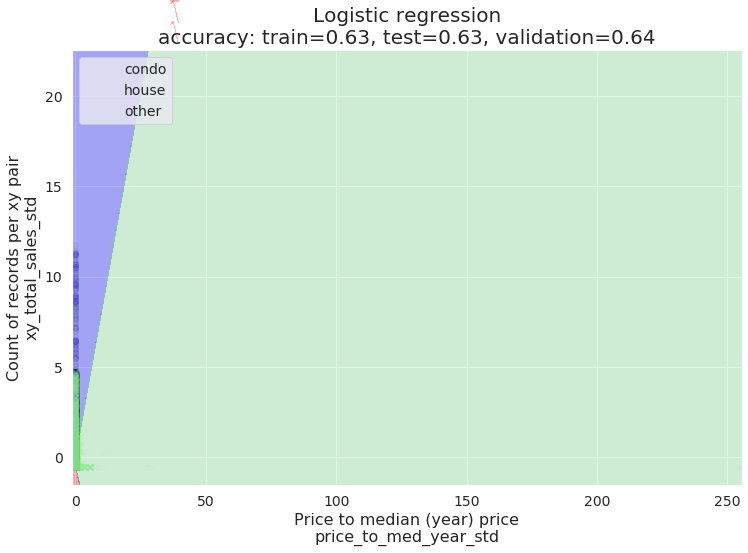

In [30]:
t = time()
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=model,
                      limits=False)
plt.xlabel("Price to median (year) price\nprice_to_med_year_std", fontsize=16)
plt.ylabel("Count of records per xy pair\nxy_total_sales_std", fontsize=16)
plt.title("Logistic regression\naccuracy: train={0:.2f}, test={1:.2f}, validation={2:.2f}"
          .format(train_score, test_score, val_score), fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=labels_list, loc='upper left', fontsize=14)
elapsed = time() - t
print("Plotting took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
plt.show()

Plotting took 4.27 seconds (0.07 minutes)


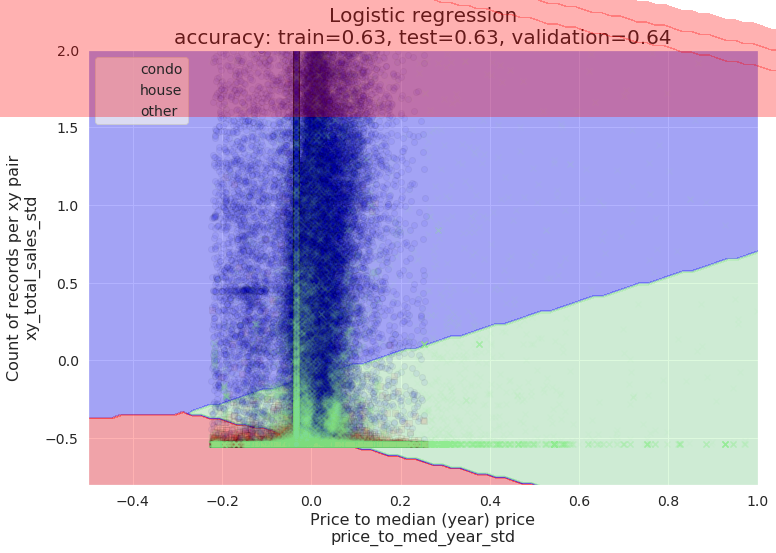

In [31]:
t = time()
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=model,
                      limits=True)
plt.xlabel("Price to median (year) price\nprice_to_med_year_std", fontsize=16)
plt.ylabel("Count of records per xy pair\nxy_total_sales_std", fontsize=16)
plt.title("Logistic regression\naccuracy: train={0:.2f}, test={1:.2f}, validation={2:.2f}"
          .format(train_score, test_score, val_score), fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=labels_list, loc='upper left', fontsize=14)
elapsed = time() - t
print("Plotting took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
plt.show()

#### Decision Tree

In [32]:
t = time()

# initialize and fit a model
model = DecisionTreeClassifier(criterion='gini',
                              max_depth=4, 
                              random_state=1)
model_name = 'Decision Tree'
model.fit(X_train_std, y_train)

# make predictions
y_pred_train = model.predict(X_train_std)
y_pred_test = model.predict(X_test_std)
y_pred_val = model.predict(X_val_std)

# score model performance
train_score = accuracy_score(y_train, y_pred_train)
test_score = accuracy_score(y_test, y_pred_test)
val_score = accuracy_score(y_val, y_pred_val)

elapsed = time() - t
print("{0} fit, took {1:,.2f} seconds ({2:,.2f} minutes)".format(model_name, elapsed, elapsed / 60))

Decision Tree fit, took 0.17 seconds (0.00 minutes)


Plotting took 4.12 seconds (0.07 minutes)


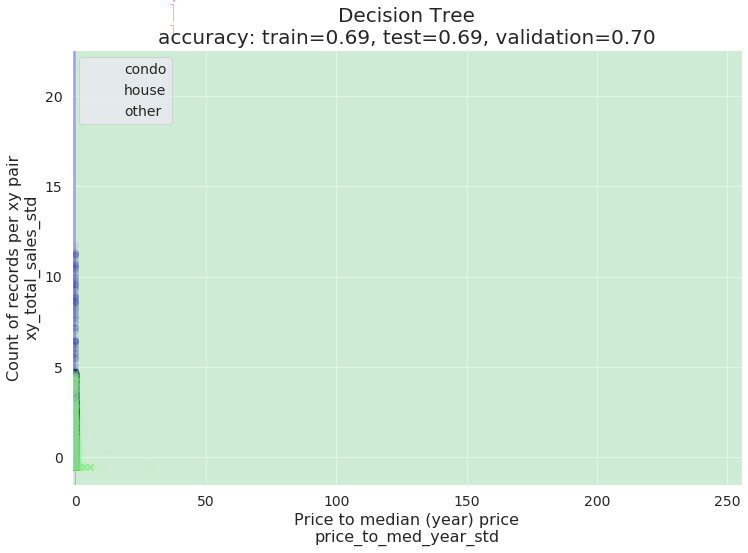

In [33]:
t = time()
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=model,
                      limits=False)
plt.xlabel("Price to median (year) price\nprice_to_med_year_std", fontsize=16)
plt.ylabel("Count of records per xy pair\nxy_total_sales_std", fontsize=16)
plt.title("{0}\naccuracy: train={1:.2f}, test={2:.2f}, validation={3:.2f}"
          .format(model_name, train_score, test_score, val_score), fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=labels_list, loc='upper left', fontsize=14)
elapsed = time() - t
print("Plotting took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
plt.show()

Plotting took 4.31 seconds (0.07 minutes)


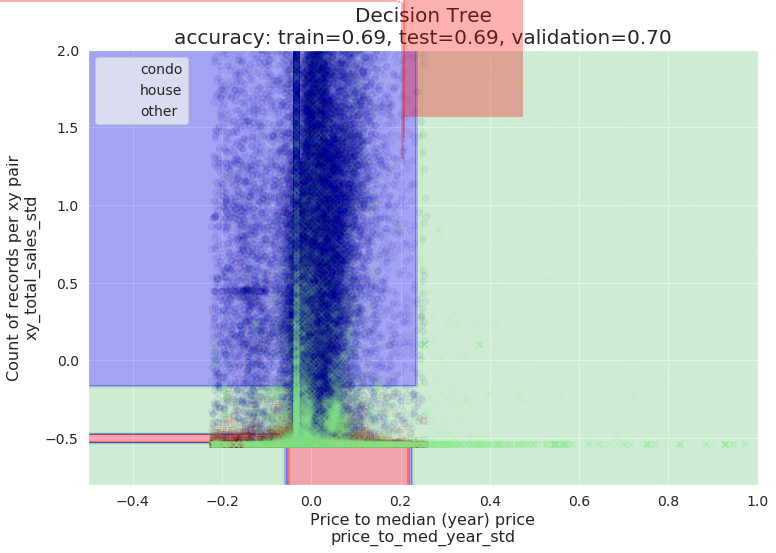

In [34]:
t = time()
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=model,
                      limits=True)
plt.xlabel("Price to median (year) price\nprice_to_med_year_std", fontsize=16)
plt.ylabel("Count of records per xy pair\nxy_total_sales_std", fontsize=16)
plt.title("{0}\naccuracy: train={1:.2f}, test={2:.2f}, validation={3:.2f}"
          .format(model_name, train_score, test_score, val_score), fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=labels_list, loc='upper left', fontsize=14)
elapsed = time() - t
print("Plotting took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
plt.show()

#### Random Forest

In [35]:
t = time()

# initialize and fit a model
model = RandomForestClassifier(criterion='gini',
                               n_estimators=25,
                               random_state=1,
                               n_jobs=2)
model_name = 'Random Forest'
model.fit(X_train_std, y_train)

# make predictions
y_pred_train = model.predict(X_train_std)
y_pred_test = model.predict(X_test_std)
y_pred_val = model.predict(X_val_std)

# score model performance
train_score = accuracy_score(y_train, y_pred_train)
test_score = accuracy_score(y_test, y_pred_test)
val_score = accuracy_score(y_val, y_pred_val)

elapsed = time() - t
print("{0} fit, took {1:,.2f} seconds ({2:,.2f} minutes)".format(model_name, elapsed, elapsed / 60))

Random Forest fit, took 7.37 seconds (0.12 minutes)


Plotting took 22.92 seconds (0.38 minutes)


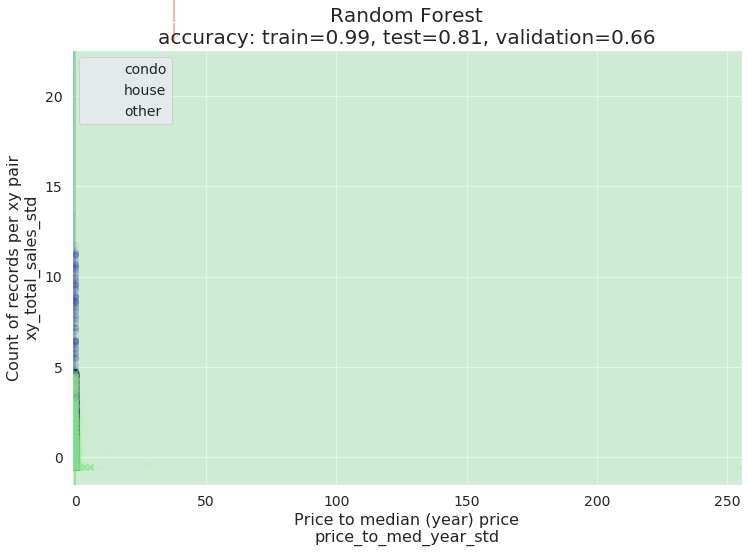

In [36]:
t = time()
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=model,
                      limits=False)
plt.xlabel("Price to median (year) price\nprice_to_med_year_std", fontsize=16)
plt.ylabel("Count of records per xy pair\nxy_total_sales_std", fontsize=16)
plt.title("{0}\naccuracy: train={1:.2f}, test={2:.2f}, validation={3:.2f}"
          .format(model_name, train_score, test_score, val_score), fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=labels_list, loc='upper left', fontsize=14)
elapsed = time() - t
print("Plotting took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
plt.show()

Plotting took 22.40 seconds (0.37 minutes)


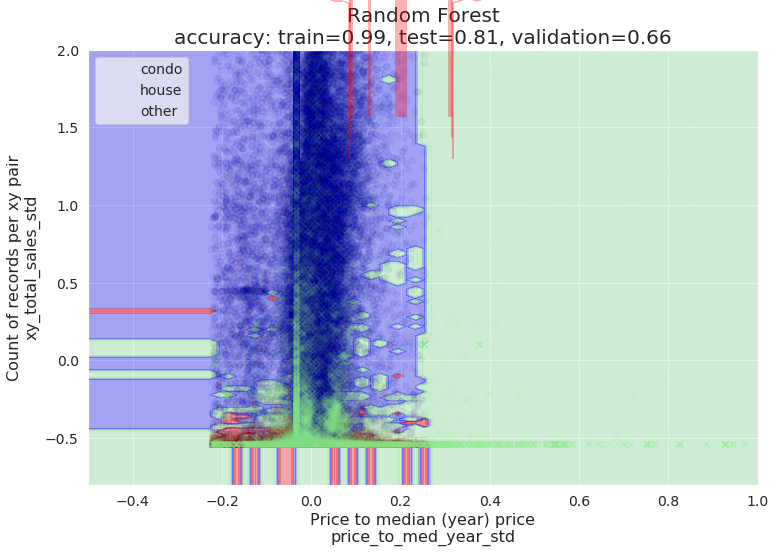

In [37]:
t = time()
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=model,
                      limits=True)
plt.xlabel("Price to median (year) price\nprice_to_med_year_std", fontsize=16)
plt.ylabel("Count of records per xy pair\nxy_total_sales_std", fontsize=16)
plt.title("{0}\naccuracy: train={1:.2f}, test={2:.2f}, validation={3:.2f}"
          .format(model_name, train_score, test_score, val_score), fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=labels_list, loc='upper left', fontsize=14)
elapsed = time() - t
print("Plotting took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
plt.show()

#### K-nearest neighbors

In [38]:
t = time()

# initialize and fit a model
model = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
model_name = 'K-nearest neighbors'
model.fit(X_train_std, y_train)

# make predictions
y_pred_train = model.predict(X_train_std)
y_pred_test = model.predict(X_test_std)
y_pred_val = model.predict(X_val_std)

# score model performance
train_score = accuracy_score(y_train, y_pred_train)
test_score = accuracy_score(y_test, y_pred_test)
val_score = accuracy_score(y_val, y_pred_val)

elapsed = time() - t
print("{0} fit, took {1:,.2f} seconds ({2:,.2f} minutes)".format(model_name, elapsed, elapsed / 60))

K-nearest neighbors fit, took 25.07 seconds (0.42 minutes)


Plotting took 871.32 seconds (14.52 minutes)


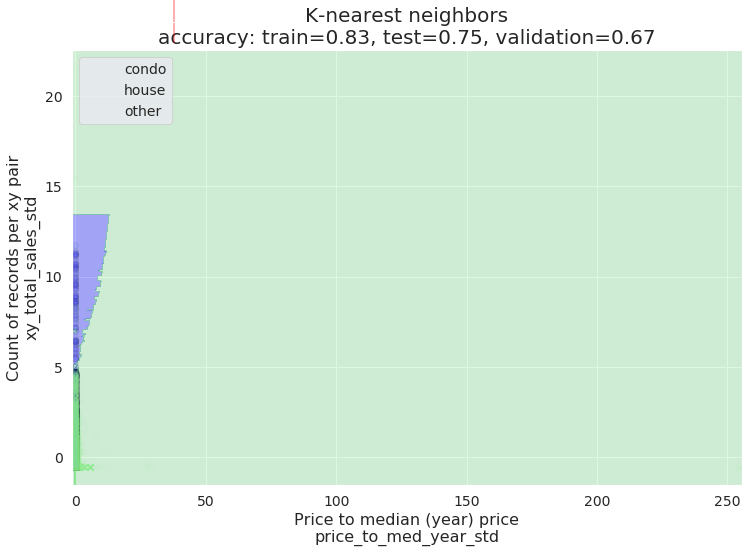

In [39]:
t = time()
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=model,
                      limits=False)
plt.xlabel("Price to median (year) price\nprice_to_med_year_std", fontsize=16)
plt.ylabel("Count of records per xy pair\nxy_total_sales_std", fontsize=16)
plt.title("{0}\naccuracy: train={1:.2f}, test={2:.2f}, validation={3:.2f}"
          .format(model_name, train_score, test_score, val_score), fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=labels_list, loc='upper left', fontsize=14)
elapsed = time() - t
print("Plotting took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
plt.show()

Plotting took 879.62 seconds (14.66 minutes)


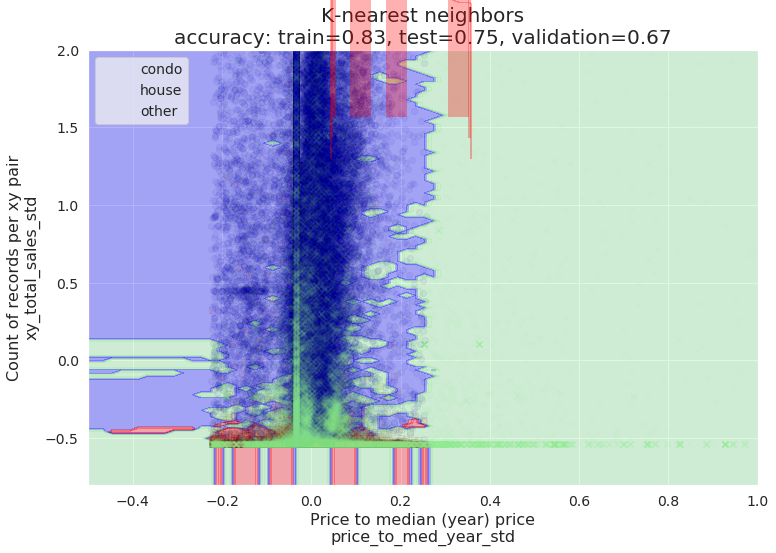

In [40]:
t = time()
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=model,
                      limits=True)
plt.xlabel("Price to median (year) price\nprice_to_med_year_std", fontsize=16)
plt.ylabel("Count of records per xy pair\nxy_total_sales_std", fontsize=16)
plt.title("{0}\naccuracy: train={1:.2f}, test={2:.2f}, validation={3:.2f}"
          .format(model_name, train_score, test_score, val_score), fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=labels_list, loc='upper left', fontsize=14)
elapsed = time() - t
print("Plotting took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
plt.show()